In [210]:
import os
import re
import glob
import nltk
import numpy as np
import pandas as pd
import pandas_access as mdb
import zipfile
import recordlinkage as rl
from os.path import join, basename
from meza import io
from params import get_params
from nltk.tokenize import word_tokenize
import seaborn as sns
sns.set_context('paper')

pd.set_option("display.max_columns", 150)

Access to database

In [193]:
## Access Birth 2020
params = get_params()
path = '/Users/pierredelice/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/Dgis/Data/nacimiento/'
file = glob.glob(join(path,r'*.csv'))
file_zip = glob.glob(join(path,r'*.zip'))
nacimiento_2020 = 'nac_unzip/Nacimientos_cierre_2020/Nacimientos_cierre_2020.csv'


#Select columns 
cols = ['FOLIO','NOMBRE','PRIMERAPELLIDO',
    'SEGUNDOAPELLIDO','CURPMADRE',
    'FECHANACIMIENTOMADRE','ENTIDADNACIMIENTO',
    'MUNICIPIONACIMIENTO','ENTIDADRESIDENCIA',
    'MUNICIPIORESIDENCIA','LOCALIDADRESIDENCIA',
    'HIJOSNACIDOSMUERTOS','HIJOSNACIDOSVIVOS',
    'AFILIACION','FECHANACIMIENTO',
    'HORANACIMIENTO','SEXO',
    'ENTIDADFEDERATIVAPARTO','MUNICIPIOPARTO',
    'LOCALIDADPARTO','CODIGOPOSTALPARTO']

#Columns to rename
name = {'PRIMERAPELLIDO':'paterno',
'SEGUNDOAPELLIDO':'materno',
'CURPMADRE':'curp',
'FECHANACIMIENTOMADRE':'fech_nac_madre',
'ENTIDADNACIMIENTO':'ent_nac_madre',
'MUNICIPIONACIMIENTO':'mun_nac_madre',
'ENTIDADRESIDENCIA':'ent_res',
'MUNICIPIORESIDENCIA':'mun_res',
'LOCALIDADRESIDENCIA':'local_res',
'HIJOSNACIDOSMUERTOS':'hijos_muertos',
'HIJOSNACIDOSVIVOS':'hijos_vivos',
'FECHANACIMIENTO':'fech_nac',
'ENTIDADFEDERATIVAPARTO':'ent_parto',
'MUNICIPIOPARTO':'mun_parto',
'LOCALIDADPARTO':'localidad_parto'}

#Read data
nac2020 = pd.read_csv(join(path,nacimiento_2020), usecols= cols, low_memory=False)

#Rename columns
nac2020.rename(columns=name, inplace =True)

#To lower case columns
nac2020.columns = [x.lower() for x in nac2020.columns]


#To lower strings columns
nac2020 = nac2020.apply(lambda x: x.astype(str).str.lower())

#Convert to string
#nac2020 = nac2020.convert_dtypes()
nac2020[['ent_nac_madre','mun_nac_madre', \
    'ent_res','mun_res','hijos_muertos', \
    'hijos_vivos', 'afiliacion','sexo', \
    'ent_parto','mun_parto','localidad_parto']] = \
nac2020[['ent_nac_madre','mun_nac_madre', \
    'ent_res','mun_res','hijos_muertos', \
    'hijos_vivos', 'afiliacion','sexo', \
    'ent_parto','mun_parto','localidad_parto']].astype('int16')

nac2020['folio'] = nac2020['folio'].astype('category')
nac2020['fech_nac'] = pd.to_datetime(nac2020['fech_nac'], format='%d/%m/%Y', errors='coerce')
nac2020['fech_nac_madre'] = pd.to_datetime(nac2020['fech_nac_madre'], format='%d/%m/%Y', errors='coerce')
nac2020['horanacimiento'] = pd.to_datetime(nac2020['horanacimiento'], errors='coerce').dt.strftime('%H:%M')

#Edad
nac2020.fech_nac_madre[nac2020.fech_nac_madre == '2089-01-27'] = '1989-01-07'
nac2020.fech_nac_madre[nac2020.fech_nac_madre == '2095-08-30'] = '1995-08-30'
nac2020['edad_madre']=(round((nac2020['fech_nac'] - nac2020['fech_nac_madre'])/np.timedelta64(1, 'Y'),0))
bins = [0,4,9,14,19,24,29,34,39,44,49,
        54,59,64,69,74,79,84,89,94,120]
labels = ['0-4','5-9','10-14','15-19',
        '20-24','25-29','30-34','35-39',
        '40-44','45-49','50-54','54-59',
        '60-64','65-69','70-74','75-79',
        '80-84','85-89','90-94', '95+']
nac2020['agerange'] = pd.cut(nac2020.edad_madre, bins, labels = labels,include_lowest = True)

#Create fullname: Nombre + Apellido materno y paterno
nac2020['name'] = nac2020[['nombre', 'paterno', 'materno']].agg(' '.join, axis=1)

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2577/1282713238.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nac2020.fech_nac_madre[nac2020.fech_nac_madre == '2089-01-27'] = '1989-01-07'
/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2577/1282713238.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nac2020.fech_nac_madre[nac2020.fech_nac_madre == '2095-08-30'] = '1995-08-30'


<AxesSubplot: xlabel='agerange', ylabel='hijos_vivos'>

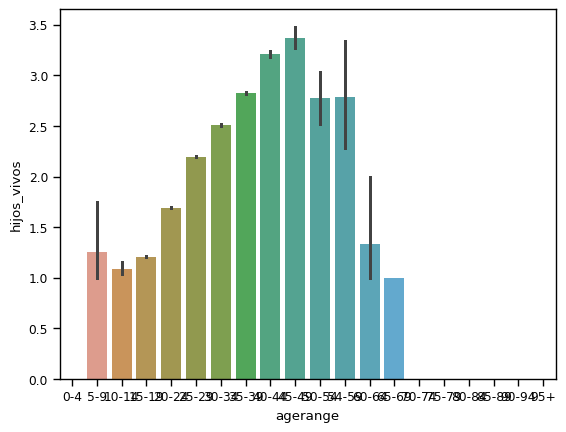

In [211]:
#nac2020.agerange.value_counts().plot(kind='bar')
sns.barplot(
        data=nac2020,
        x="agerange",
        y="hijos_vivos",
        #hue="party",
        #palette=['blue', 'red', 'yellow', 'grey'],
        saturation=0.6,
    )

In [ ]:
nac2020

Entity cleansing

In [3]:
#Selección de los registros a corregir
RE_SUSPICIOUS = re.compile(r'desconocido|se ignora|sin informacion|[&#<>{}\[\]\\]')

def impurity(text, min_len=3):
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len:
        return 0 
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

# add new column to data frame
nac2020['impurity_before'] = nac2020['name'].apply(impurity, min_len=3)

# get the top 3 records
#nac2020[['name', 'impurity_before']].sort_values(by='impurity_before', ascending=False)

,name,impurity_before
769960,sin informacion sin informacion sin informacion,0.06383
316223,sin informacion sin informacion sin informacion,0.06383
1409568,sin informacion sin informacion sin informacion,0.06383
1694356,sin informacion sin informacion sin informacion,0.06383
1313884,sin informacion sin informacion sin informacion,0.06383
...,...,...
582884,alicia urbina maldonado,0.00000
582883,lourdes ferrer ladino,0.00000
582882,irene huerta ferrer,0.00000
582881,marina morales bajonero,0.00000


In [4]:
len(nac2020[nac2020.impurity_before>0])

2306

In [5]:
def clean(text):
    # convert html escapes like &amp; to characters.
    #text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', '', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', '', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # Unnecessary words and characters
    text = re.sub(r'desconocido|se ignora|sin informacion|informacion|[&#<>{}\[\]\\]','', text)
    return text

nac2020['clean_name'] = nac2020['name'].map(clean)
#nac2020['impurity'] = nac2020['clean_name'].apply(impurity, min_len=3)
#nac2020[['clean_name', 'impurity']].sort_values(by='impurity', ascending=False).head(3)
nac2020[nac2020['clean_name'].apply(impurity, min_len=3) > 0]

,folio,curp,nombre,paterno,materno,fech_nac_madre,ent_nac_madre,mun_nac_madre,ent_res,mun_res,local_res,hijos_muertos,hijos_vivos,afiliacion,fech_nac,horanacimiento,sexo,ent_parto,mun_parto,localidad_parto,codigopostalparto,name,impurity_before,clean_name


In [6]:
from collections import Counter

counter = Counter()

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter 
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data 
    counter = Counter() 
    
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq') 
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

count_words(nac2020, column='clean_name', preprocess=lambda t: re.findall(r'desconocido|se ignora|sin informacion|[?&#<>{}\[\]\\]*', t))

,freq
token,
,47357809


In [7]:
nac2020[['clean_name','name','nombre','paterno','materno']].isnull().sum()

clean_name    0
name          0
nombre        0
paterno       0
materno       0
dtype: int64

In [8]:
(nac2020[['name','clean_name']].nunique())

name          1657455
clean_name    1657002
dtype: int64

In [9]:
(nac2020[['name','clean_name']].nunique()/len(nac2020))

name          0.948284
clean_name    0.948025
dtype: float64

<AxesSubplot: >

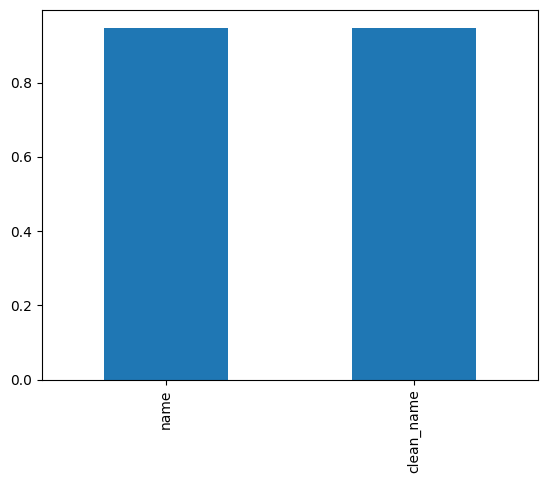

In [10]:
(nac2020[['name','clean_name']].nunique()/len(nac2020)).plot(kind='bar')

In [11]:
from recordlinkage.standardise import phonetic


class soundex():
    def soundex_met(nac2020):
        return nac2020.assign(nombre_soundex=phonetic(nac2020['clean_name'],
                                                 method='soundex'))

    def result(nac2020):
        return nac2020.assign(
            id_soundex=nac2020[['nombre_soundex']].agg(''.join, axis=1))
        return id_soundex


nac2020 = soundex.soundex_met(nac2020)
nac2020 = soundex.result(nac2020)

In [12]:
nac = nac2020.sample(n= 100000, random_state=1)

In [13]:
from recordlinkage.index import Block
block_id_soundex = Block(on=['nombre_soundex'])
block_id_s = block_id_soundex.index(nac)
print(f"No of pairs: {len(block_id_s)}")

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2577/2239741818.py:2: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  block_id_soundex = Block(on=['nombre_soundex'])


No of pairs: 18505800


In [14]:
cols = ['folio', 'clean_name','curp', 'fech_nac_madre',
       'ent_nac_madre', 'mun_nac_madre',
       'ent_res',  'mun_res','local_res', 
       'afiliacion','fech_nac', 'horanacimiento',
       'sexo', 'ent_parto',
       'mun_parto', 'localidad_parto']
nac = nac2020[cols]

In [146]:
import time

start_time = time.time()

#Blocking for CANDIDATE PAIRS
Block_id = Block(on=['clean_name', 'fech_nac_madre', 'ent_nac_madre',
'mun_nac_madre', 'curp', 'ent_res','mun_res','horanacimiento'])
Block_id_pairs = Block_id.index(nac)

#pairs = Block_name_pairs.union(Block_id_pairs)
print("--- %s seconds ---" % (time.time() - start_time))

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2577/2174118127.py:6: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  Block_id = Block(on=['clean_name', 'fech_nac_madre', 'ent_nac_madre',


--- 4.612626314163208 seconds ---


In [147]:
print('Número de duplicados',len(Block_id_pairs))
print('Porcentaje de duplicados',100*len(Block_id_pairs)/len(nac))
Block_id_pairs

Número de duplicados 1087
Porcentaje de duplicados 0.06219079816482793


MultiIndex([( 141030,     249),
            (   2027,    1666),
            (   6967,    6966),
            (  11269,   11268),
            (  13436,   13435),
            (  14030,   14029),
            ( 671075,   16256),
            (  16562,   16534),
            (  17092,   17091),
            (  18631,   18592),
            ...
            (1717351, 1717332),
            (1723586, 1722199),
            (1733848, 1722720),
            (1723071, 1723015),
            (1723041, 1723040),
            (1731535, 1724540),
            (1725197, 1725063),
            (1735970, 1734958),
            (1740127, 1735733),
            (1747671, 1744073)],
           length=1087)

In [148]:
nac0 = nac2020.loc[Block_id_pairs.to_flat_index().str[0]]
nac1 = nac2020.loc[Block_id_pairs.to_flat_index().str[1]]
nac_dup = pd.concat([nac1,nac0])


In [149]:
nac_dup.sort_values(by = ['clean_name'],axis=0)

,folio,curp,nombre,paterno,materno,fech_nac_madre,ent_nac_madre,mun_nac_madre,ent_res,mun_res,local_res,hijos_muertos,hijos_vivos,afiliacion,fech_nac,horanacimiento,sexo,ent_parto,mun_parto,localidad_parto,codigopostalparto,name,impurity_before,clean_name,nombre_soundex,id_soundex
1138034,027158238,auet940425mdfgsr05,\tteresa de jesus,aguilar,espinosa,1994-04-25,15,65,15,65,1,0,2,8,2020-04-16,17:35,1,15,33,1,55000.0,\tteresa de jesus aguilar espinosa,0.0,teresa de jesus aguilar espinosa,T623,T623
1138035,027158319,auet940425mdfgsr05,\tteresa de jesus,aguilar,espinosa,1994-04-25,15,65,15,65,1,0,3,8,2020-04-16,17:35,1,15,33,1,55000.0,\tteresa de jesus aguilar espinosa,0.0,teresa de jesus aguilar espinosa,T623,T623
742267,027567931,xxxx999999xxxxxx99,abigail,cruz,sanchez,1984-05-29,20,397,20,397,30,0,1,10,2020-04-07,20:46,1,20,397,1,69800.0,abigail cruz sanchez,0.0,abigail cruz sanchez,A124,A124
737057,027567969,xxxx999999xxxxxx99,abigail,cruz,sanchez,1984-05-29,20,397,20,397,30,0,1,10,2020-04-07,20:46,1,20,397,1,69800.0,abigail cruz sanchez,0.0,abigail cruz sanchez,A124,A124
825804,027760438,doza960206mgtrxb08,abigail,dorado,zuñiga,1996-02-06,11,43,22,14,1,0,1,2,2020-12-03,15:00,1,22,14,1,76000.0,abigail dorado zuñiga,0.0,abigail dorado zuñiga,A124,A124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154835,026816778,ropy040530mgrmrra1,yuritzy josabeth,roman,peralta,2004-05-30,12,35,12,17,1,0,1,7,2020-09-11,17:50,1,12,35,1,40000.0,yuritzy josabeth roman peralta,0.0,yuritzy josabeth roman peralta,Y632,Y632
632493,02734e00028080,xxxx999999xxxxxx99,zayda julissa,hernandez,sandoval,1998-08-26,5,30,5,30,1,0,2,7,2020-01-05,18:40,2,5,30,1,25020.0,zayda julissa hernandez sandoval,0.0,zayda julissa hernandez sandoval,Z324,Z324
608113,02734e00028103,xxxx999999xxxxxx99,zayda julissa,hernandez,sandoval,1998-08-26,5,30,5,30,1,0,2,7,2020-01-05,18:40,2,5,30,1,25020.0,zayda julissa hernandez sandoval,0.0,zayda julissa hernandez sandoval,Z324,Z324
810128,028519252,pegz951027mcsrrr02,zorayda,perez,garcia,1995-10-27,7,27,7,27,64,0,2,2,2020-09-16,22:02,1,7,101,1,29000.0,zorayda perez garcia,0.0,zorayda perez garcia,Z631,Z631


In [155]:
nac_dup.fech_nac_madre = nac_dup.fech_nac_madre.astype(str).

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 249 to 1747671
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   folio              2174 non-null   category
 1   curp               2174 non-null   object  
 2   nombre             2174 non-null   object  
 3   paterno            2174 non-null   object  
 4   materno            2174 non-null   object  
 5   fech_nac_madre     2174 non-null   object  
 6   ent_nac_madre      2174 non-null   object  
 7   mun_nac_madre      2174 non-null   object  
 8   ent_res            2174 non-null   int16   
 9   mun_res            2174 non-null   int16   
 10  local_res          2174 non-null   object  
 11  hijos_muertos      2174 non-null   int16   
 12  hijos_vivos        2174 non-null   int16   
 13  afiliacion         2174 non-null   int16   
 14  fech_nac           2174 non-null   object  
 15  horanacimiento     2174 non-null   object  
 16  s

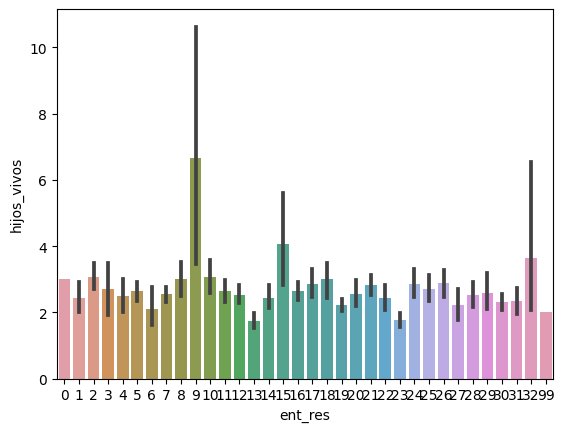

In [154]:
import seaborn as sns

ax = sns.barplot(
        data=nac_dup,
        x="ent_res",
        y="hijos_vivos",
        #hue="party",
        #palette=['blue', 'red', 'yellow', 'grey'],
        saturation=0.6,
    )

Word embeddings

In [19]:
nac2020.fech_nac_madre = nac2020.fech_nac_madre.astype(str)
nac2020.ent_nac_madre = nac2020.ent_nac_madre.astype(str)
nac2020.mun_nac_madre = nac2020.mun_nac_madre.astype(str)
nac2020.fech_nac = nac2020.fech_nac.astype(str)
id = nac2020[['clean_name','fech_nac_madre','ent_nac_madre', \
    'mun_nac_madre','fech_nac']].agg(' '.join, axis=1)

In [144]:
id = nac2020.clean_name[:100].apply(word_tokenize)

In [145]:
id

0         [nancy, graciela, ojeda, guevara]
1                [andrea, de, leon, rivera]
2             [diana, areli, sosa, vazquez]
3          [nadia, magali, flores, cantelo]
4     [zaida, yolanda, bobadilla, serralde]
                      ...                  
95                  [esli, montoya, torres]
96              [helen, sanchez, revueltas]
97                      [joana, rios, cruz]
98       [mora, itzel, cardenas, hernandez]
99                [josefina, vargas, ojeda]
Name: clean_name, Length: 100, dtype: object

In [136]:
# create K-shingles by sliding window approach
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1
doc_shingles = [getShingles(s, 5) for s in id]

Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 4 possible.
Found 0 unique shingles, out of 3 possible.
Found 0 unique shingles, out of 

In [137]:
doc_shingles

[set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set()]

In [119]:
import itertools
def jaccardSim(d1,d2):
    return len(d1.intersection(d2))/len(d1.union(d2))

# itertools.combinations finds all (,n) n-pairs
# then we use a map op on the tuples with jaccardSim
pairs = itertools.combinations(id, 2)
pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
print(f"**~~~~~~ True similarity scores ~~~~~~**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    print(f"{pair}\t{score:.3f}")

**~~~~~~ True similarity scores ~~~~~~**
Pair	Score
--------------
(0, 1)	0.000
(0, 2)	0.000
(0, 3)	0.000
(0, 4)	0.000
(0, 5)	0.000
(0, 6)	0.000
(0, 7)	0.000
(0, 8)	0.000
(0, 9)	0.000
(0, 10)	0.000
(0, 11)	0.000
(0, 12)	0.000
(0, 13)	0.000
(0, 14)	0.000
(0, 15)	0.000
(0, 16)	0.000
(0, 17)	0.000
(0, 18)	0.000
(0, 19)	0.000
(0, 20)	0.000
(0, 21)	0.000
(0, 22)	0.000
(0, 23)	0.000
(0, 24)	0.000
(0, 25)	0.000
(0, 26)	0.000
(0, 27)	0.000
(0, 28)	0.000
(0, 29)	0.000
(0, 30)	0.000
(0, 31)	0.000
(0, 32)	0.000
(0, 33)	0.000
(0, 34)	0.000
(0, 35)	0.000
(0, 36)	0.000
(0, 37)	0.000
(0, 38)	0.000
(0, 39)	0.000
(0, 40)	0.000
(0, 41)	0.000
(0, 42)	0.000
(0, 43)	0.000
(0, 44)	0.000
(0, 45)	0.000
(0, 46)	0.000
(0, 47)	0.000
(0, 48)	0.000
(0, 49)	0.000
(0, 50)	0.000
(0, 51)	0.000
(0, 52)	0.000
(0, 53)	0.045
(0, 54)	0.000
(0, 55)	0.000
(0, 56)	0.000
(0, 57)	0.000
(0, 58)	0.000
(0, 59)	0.000
(0, 60)	0.000
(0, 61)	0.000
(0, 62)	0.022
(0, 63)	0.000
(0, 64)	0.000
(0, 65)	0.000
(0, 66)	0.000
(0, 67)	0.021
(0, 

In [120]:
# Take union of all sets. Convert to an array and assign
# each element an integer based on position in array
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")

There are 1533 shingles


In [121]:
# Create a hash function
# define as a callable class, so that we only
# intialize random functions once
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


In [122]:
hm = HashManager(shingle_dict)

In [123]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
#     cols = [sig_mat[:,i] for i in range(sig_mat.shape[1])]
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))
    
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"**~~~~~~ Similarity score comparison ~~~~~~**")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        err = 100*abs(true_value-approx_value)/true_value
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{err:.2f}")

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
    false_negatives = len(true_pairs - approx_pairs)
    false_positives = len(approx_pairs - true_pairs)
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

# print(f"**~~~~~~ Approximate similarity scores ~~~~~~**")
# print("Pair\t\tApproximate Score\t\tTrue Score")
# print("-"*14)
# for pair, score in sigSimScores(sig_mat):
#     print(f"{pair}\t{score:.3f}")
    
# print(f"**~~~~~~ True similarity scores ~~~~~~**")
# print("Pair\tScore")
# print("-"*14)
# for pair, score in zip(pair_labels, pair_sims):
#     print(f"{pair}\t{score:.3f}")

**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.000		0.000		nan
(0, 2)		0.000		0.000		nan
(0, 3)		0.100		0.000		inf
(0, 4)		0.000		0.000		nan
(0, 5)		0.000		0.000		nan
(0, 6)		0.000		0.000		nan
(0, 7)		0.000		0.000		nan
(0, 8)		0.000		0.000		nan
(0, 9)		0.000		0.000		nan
(0, 10)		0.000		0.000		nan
(0, 11)		0.100		0.000		inf
(0, 12)		0.100		0.000		inf
(0, 13)		0.000		0.000		nan
(0, 14)		0.000		0.000		nan
(0, 15)		0.000		0.000		nan
(0, 16)		0.000		0.000		nan
(0, 17)		0.100		0.000		inf
(0, 18)		0.000		0.000		nan
(0, 19)		0.000		0.000		nan
(0, 20)		0.100		0.000		inf
(0, 21)		0.000		0.000		nan
(0, 22)		0.100		0.000		inf
(0, 23)		0.000		0.000		nan
(0, 24)		0.000		0.000		nan
(0, 25)		0.000		0.000		nan
(0, 26)		0.100		0.000		inf
(0, 27)		0.000		0.000		nan
(0, 28)		0.000		0.000		nan
(0, 29)		0.000		0.000		nan
(0, 30)		0.000		0.000		nan
(0, 31)		0.000		0.000		nan
(0, 32)		0.000		0.000		nan
(0, 33)		0.000		0.000		nan
(0, 34)		0.100		0.000		inf
(0, 35)		0.000		0.

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2577/3308397093.py:28: RuntimeWarning: invalid value encountered in scalar divide
  err = 100*abs(true_value-approx_value)/true_value
/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2577/3308397093.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  err = 100*abs(true_value-approx_value)/true_value


In [132]:
candidatePairs(true_score_dict, 0.20)

{(1, 50), (5, 18), (13, 75), (33, 42), (33, 45), (39, 88), (41, 91), (66, 73)}

In [133]:
id.loc[[1,50,5,18,33,45,39,88,41,91,66,73]]

1                 andrea de leon rivera
50                  karina de leon diaz
5              monica rodriguez jimenez
18    brenda elizabeth rodriguez jaimes
33         martha elena gonzalez ortega
45           martha elena flores sierra
39           elizabeth gonzalez huertas
88      navil getsemani gonzalez huerta
41             celina vasquez hernandez
91           blanca hernandez hernandez
66          karka ivette leon rodriguez
73               cecilia leon rodriguez
Name: clean_name, dtype: object

In [126]:
id.loc[[81,82]]

81     fatima yaquelin saenz espinoza
82    leslie angelica guevara sanchez
Name: clean_name, dtype: object